In [1]:
cd ../..

/home/asingal/home/quisp/SeQUeNCe_quisp


/home/asingal/home/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from datetime import date, datetime

from src.topology.router_net_topo import RouterNetTopo
from src.app.request_app import RequestApp
import src.utils.log as log

In [3]:
today = date.today()

CONFIG_FILE = "example/SC24/config_files/simple_link.json"

# meta params
NO_TRIALS = 10
LOGGING = False
LOG_OUTPUT = "example/SC24/exp_1_log.txt"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app"]

In [4]:
# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(3e12)  # 10 seconds

# qc params
QC_FREQ = 1e11

# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memories = [1,2,4,8,16,32,64]  # iterate through these

# storing data
data_dict = {"Memory Count": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average TTT": [],
             "Std. TTT":[],
             }

In [5]:
collect_time_base = COLLECT_TIME

for i, num_memo in enumerate(num_memories):
    print(f"Running {NO_TRIALS} trials for memory count {num_memo} ({i + 1}/{len(num_memories)})")
    data_dict["Memory Count"].append(num_memo)
    throughputs = np.zeros(NO_TRIALS)
    time_to_thousand = np.zeros(NO_TRIALS)

    COLLECT_TIME = collect_time_base/num_memo

    for trial_no in range(NO_TRIALS):
        # establish network
        net_topo = RouterNetTopo(CONFIG_FILE)

        # timeline setup
        tl = net_topo.get_timeline()
        tl.stop_time = PREP_TIME + COLLECT_TIME

        if LOGGING:
            # set log
            if num_memo == num_memories[0]:
                log.set_logger(__name__, tl, LOG_OUTPUT)
                log.set_logger_level('WARN')
                for module in MODULE_TO_LOG:
                    log.track_module(module)
            elif num_memo == num_memories[1]:
                for module in MODULE_TO_LOG:
                    log.remove_module(module)

        # network configuration
        routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
        bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

        for j, node in enumerate(routers + bsm_nodes):
            node.set_seed(int(datetime.now().timestamp()) + j + (trial_no * 3))

        # set quantum channel parameters
        for qc in net_topo.get_qchannels():
            qc.frequency = QC_FREQ

        # establish app on left node
        start_node = None
        for node in routers:
            if node.name == APP_NODE_NAME:
                start_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
        end_node = None
        for node in routers:
            if node.name == OTHER_NODE_NAME:
                end_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

        app_start = RequestApp(start_node)
        app_end = RequestApp(end_node)

        # initialize and start app
        tl.init()
        app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1.0)
        tl.run()

        # Used for debugging
        # attempt = app_start.node.total_attempts
        # success = app_start.node.succesful_attempts
        # prob = success/attempt

        throughputs[trial_no] = app_start.get_throughput()        
        time_to_thousand[trial_no] = app_start.node.time_to_thousand
        

        print(f"\tCompleted trial {trial_no + 1}/{NO_TRIALS}")



    print("Finished trials.")

    avg_throughput = np.mean(throughputs)
    std_throughput = np.std(throughputs)
    avg_TTT = np.mean(time_to_thousand)*1e-12
    std_TTT = np.std(time_to_thousand)*1e-12
    
    print(f"Average throughput: {avg_throughput} +/- {std_throughput}")
    print(f"time to thousand entanglements:", time_to_thousand)

    data_dict["Average Throughput"].append(avg_throughput)
    data_dict["Std. Throughput"].append(std_throughput)
    data_dict["Average TTT"].append(avg_TTT)
    data_dict["Std. TTT"].append(std_TTT)
             

df = pd.DataFrame(data_dict)

Running 10 trials for memory count 1 (1/7)
	Completed trial 1/10
	Completed trial 2/10
	Completed trial 3/10
	Completed trial 4/10
	Completed trial 5/10
	Completed trial 6/10
	Completed trial 7/10
	Completed trial 8/10
	Completed trial 9/10
	Completed trial 10/10
Finished trials.
Average throughput: 502.3 +/- 7.475069676375379
time to thousand entanglements: [1.99760010e+12 1.97200010e+12 1.87080009e+12 2.06280010e+12
 1.98440010e+12 1.97000010e+12 2.00280010e+12 1.98600010e+12
 2.04080010e+12 2.06920010e+12]
Running 10 trials for memory count 2 (2/7)
	Completed trial 1/10
	Completed trial 2/10
	Completed trial 3/10
	Completed trial 4/10
	Completed trial 5/10
	Completed trial 6/10
	Completed trial 7/10
	Completed trial 8/10
	Completed trial 9/10
	Completed trial 10/10
Finished trials.
Average throughput: 994.1999999999998 +/- 24.427761984176005
time to thousand entanglements: [9.80400049e+11 9.95600050e+11 9.88800049e+11 9.89600049e+11
 1.00800005e+12 9.72800049e+11 1.01680005e+12 1.01

,Memory Count,Average Throughput,Std. Throughput,Average TTT,Std. TTT
0,1,502.300000,7.475070,1.99564,0.053886
1,2,994.200000,24.427762,1.00080,0.020960
2,4,2006.000000,42.299462,0.49680,0.014937
3,8,3967.466667,41.957439,0.25040,0.003774
4,16,7787.733333,169.610063,0.12800,0.003705
5,32,15883.733333,216.480782,0.06328,0.001908
6,64,31822.933333,629.101878,0.03140,0.000699


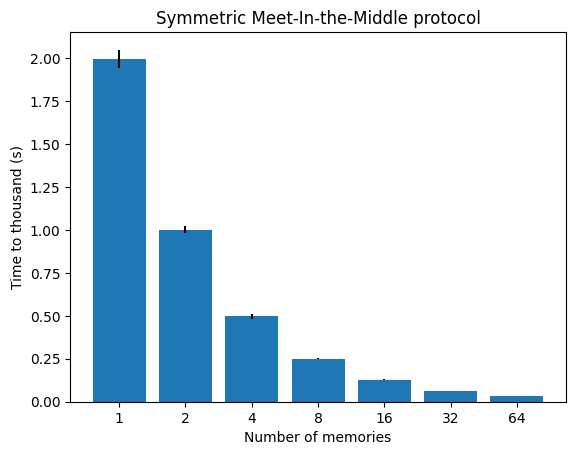

In [6]:
plt.bar(range(len(df["Average TTT"])), df["Average TTT"], yerr = df["Std. TTT"], tick_label = df["Memory Count"])
plt.ylabel("Time to thousand (s)")
plt.xlabel("Number of memories")
plt.title("Symmetric Meet-In-the-Middle protocol")
df